In [134]:
import mlrose_hiive as mlrose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.compose import make_column_transformer

from mlrose_hiive import MaxKColorGenerator, QueensGenerator, FlipFlopGenerator,\
      TSPGenerator, KnapsackGenerator, ContinuousPeaksGenerator
from mlrose_hiive import SARunner, GARunner, NNGSRunner, MIMICRunner, RHCRunner
from mlrose_hiive import SKMLPRunner

In [135]:
red_wine = os.path.join('data','wine', 'winequality-red.csv')
white_wine = os.path.join('data','wine', 'winequality-white.csv')
turbine = os.path.join('data','turbine','gt_2011.csv')
mushrooms = os.path.join('data','mushroom','secondary_data.csv')

In [136]:
# encoders to use
scale = StandardScaler()
s_split = ShuffleSplit()
ohe = OneHotEncoder(sparse_output=False)

In [137]:
transformer = make_column_transformer(
    (
        ohe, 
        [
        'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 
       'stem-root', 'stem-surface', 'stem-color','veil-type', 'veil-color',
        'has-ring', 'ring-type', 'spore-print-color','habitat', 'season'
        ]
        ),
    remainder='passthrough'
    )

In [138]:
shroom_df = pd.read_csv(mushrooms,sep=';').sample(frac=1).reset_index(drop=True)
x = shroom_df.iloc[:,1:].copy()
x_shroom = pd.DataFrame(transformer.fit_transform(x), 
                columns=transformer.get_feature_names_out())
y = shroom_df.iloc[:,0].copy()
y_shroom = (y == 'p')


# reduce the number of training examples
x_shroom = x_shroom[:7000]
y_shroom =  y_shroom[:7000]

## Train Test Split

In [139]:
x_shroom_train, x_shroom_test, y_shroom_train, y_shroom_test = train_test_split(
    x_shroom, y_shroom, test_size=0.2)

## Define Fitness Functions

### N-Queens

In [73]:
fitness = mlrose.Queens()
four_fitness = mlrose.FourPeaks()
weights = [10, 5, 2, 8, 15, 13, 18, 25]
values = list(np.arange(1, 9))
max_weight_pct = 0.5
knap_fitness = mlrose.Knapsack(weights, values, max_weight_pct)

In [77]:
problem = mlrose.DiscreteOpt(
    length = 8, fitness_fn = fitness, 
    maximize = False, max_val = 8
    )

four_problem = mlrose.DiscreteOpt(
    length = 8, fitness_fn = four_fitness, 
    maximize = False, max_val = 2
    )

knap_problem = mlrose.DiscreteOpt(
    length = 8, fitness_fn = knap_fitness, 
    maximize = False, max_val = 8
    )

In [78]:
import numpy as np
weights = [10, 5, 2, 8, 15]
values = [1, 2, 3, 4, 5]
max_weight_pct = 0.6
fitness = mlrose.Knapsack(weights, values, max_weight_pct)
state = np.array([1, 0, 2, 1, 0])
fitness.evaluate(state)

11

In [79]:
# a function to run an N-queens problem using
# define a fitness function

In [82]:
# Define decay schedule
schedule = mlrose.ExpDecay()

# Define initial state
init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

# Solve problem using simulated annealing
best_state, best_fitness, curve = mlrose.simulated_annealing(
    four_problem, schedule = schedule,
    max_attempts = 10, max_iters = 1000,
    init_state = init_state, random_state = 123321,
    curve=True
    )

print(best_state)
print(best_fitness)
fig, ax = plt.subplots()
ax.plot(curve[:,1], curve[:,0])
plt.show()

TypeError: SARunner.__init__() missing 4 required positional arguments: 'experiment_name', 'seed', 'iteration_list', and 'temperature_list'

[7 3 0 5 6 7 2 3]
0.0


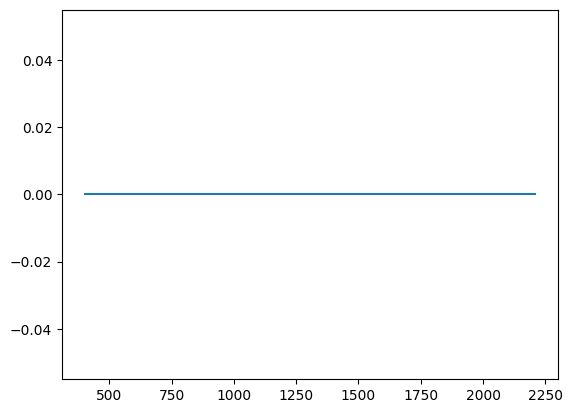

In [37]:
# Solve problem using MIMIC
best_state, best_fitness, curve = mlrose.mimic(
    four_problem, max_attempts = 10, max_iters = 1000,
    random_state = 123321, curve=True
    )

print(best_state)
print(best_fitness)
fig, ax = plt.subplots()
ax.plot(curve[:,1], curve[:,0])
plt.show()

In [118]:
# create a runner class and solve the problem
sa_run = SARunner(problem=four_problem,
              experiment_name='queens8_sa',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0],
              decay_list=[mlrose.GeomDecay])

# the two data frames will contain the results
df_run_stats, df_run_curves = sa_run.run()

In [119]:
df_run_curves

,Iteration,Time,Fitness,FEvals,Temperature,max_iters
0,0,0.000744,1.0,0.0,0.1,1024
1,1,0.006017,1.0,2.0,0.1,1024
2,0,0.000744,1.0,0.0,0.5,1024
3,1,0.006017,1.0,2.0,0.5,1024
4,0,0.000744,1.0,0.0,0.75,1024
5,1,0.006017,1.0,2.0,0.75,1024
6,0,0.000744,1.0,0.0,1.0,1024
7,1,0.006017,1.0,2.0,1.0,1024
8,0,0.000744,1.0,0.0,2.0,1024
9,1,0.006017,1.0,2.0,2.0,1024


In [87]:
# create a runner class and solve the problem
mimic_run = MIMICRunner(problem=problem,
              experiment_name='queens8_sa',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              population_sizes = [200],
              keep_percent_list = [0.25, 0.5, 0.75]
              )

# the two data frames will contain the results
df_run_stats, df_run_curves = mimic_run.run()

In [115]:
df_run_curves

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
0,0,0.001342,11.0,0.0,25,1024,0
1,1,0.003292,9.0,2.0,25,1024,0
2,2,0.004776,8.0,4.0,25,1024,0
3,3,0.006474,8.0,5.0,25,1024,0
4,4,0.007471,7.0,7.0,25,1024,0
...,...,...,...,...,...,...,...
109163,1,0.003292,6.0,51477.0,100,1024,96
109164,1,0.003292,9.0,51479.0,100,1024,97
109165,1,0.003292,11.0,51480.0,100,1024,98
109166,1,0.003292,6.0,51481.0,100,1024,99


In [120]:
sa_run.runner_name()

'sa'

In [92]:
# create a runner class and solve the problem
ga_run = GARunner(problem=problem,
              experiment_name='queens8_sa',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              population_sizes = [200],
              mutation_rates = [0.25, 0.5, 0.75]
              )

# the two data frames will contain the results
df_run_stats, df_run_curves = ga_run.run()

"\n\n        return super().run_experiment_(algorithm=mlrose_hiive.genetic_alg,\n                                       pop_size=('Population Size', self.population_sizes),\n                                       mutation_prob=('Mutation Rate', self.mutation_rates),\n                                       hamming_factor=('Hamming Factor', self.hamming_factors),\n                                       hamming_decay_factor=('Hamming Factor Decay Rate', self.hamming_factor_decays))\n"

In [93]:
df_run_curves

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
0,0,0.051773,11.0,200.0,200,0.25,1024
1,1,0.107367,1.0,402.0,200,0.25,1024
2,2,0.152979,1.0,603.0,200,0.25,1024
3,3,0.198509,1.0,804.0,200,0.25,1024
4,4,0.240348,1.0,1005.0,200,0.25,1024
...,...,...,...,...,...,...,...
1563,528,0.502997,0.0,106330.0,200,0.75,1024
1564,529,0.551923,0.0,106531.0,200,0.75,1024
1565,530,0.598189,0.0,106732.0,200,0.75,1024
1566,531,0.642227,0.0,106933.0,200,0.75,1024


In [96]:
# create a runner class and solve the problem
rhc_run = RHCRunner(problem=problem,
              experiment_name='queens8_sa',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              restart_list=[25, 75, 100]
              )

# the two data frames will contain the results
df_run_stats, df_run_curves = rhc_run.run()

In [108]:
df_run_curves[(df_run_curves['Fitness']==0) & (df_run_curves['Iteration']<20)]

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
53098,16,0.016246,0.0,38806.0,75,1024,68
53099,17,0.018033,0.0,38807.0,75,1024,68
53100,18,0.018371,0.0,38808.0,75,1024,68
53101,19,0.018657,0.0,38809.0,75,1024,68
96591,16,0.016246,0.0,38806.0,100,1024,68
96592,17,0.018033,0.0,38807.0,100,1024,68
96593,18,0.018371,0.0,38808.0,100,1024,68
96594,19,0.018657,0.0,38809.0,100,1024,68


[6 5 2 4 7 5 1 3]
5.0


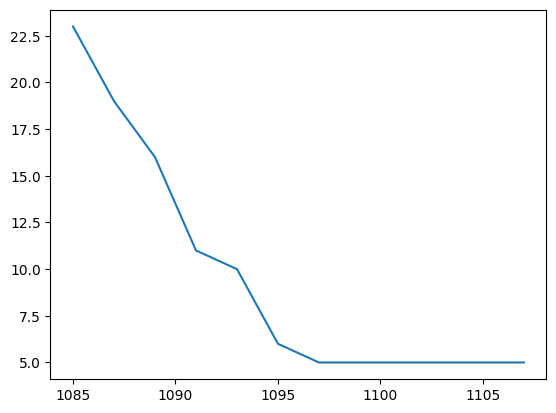

In [36]:
# Define initial state
init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

# Solve problem using simulated annealing
best_state, best_fitness, curve = mlrose.random_hill_climb(
    problem, max_attempts = 10, max_iters = 1000,
    init_state = init_state, random_state = 123321,
    curve=True
    )

print(best_state)
print(best_fitness)
fig, ax = plt.subplots()
ax.plot(curve[:,1], curve[:,0])
plt.show()

In [ ]:
# Define initial state
init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

# Solve problem using genetic algorithms
best_state, best_fitness, curve = mlrose.genetic_alg(
    problem, pop_size=200, mutation_prob=0.1, max_attempts=10, 
    max_iters=1000, curve=True, random_state=123321
    )

print(best_state)
print(best_fitness)
fig, ax = plt.subplots()
ax.plot(curve[:,1], curve[:,0])
plt.show()

In [ ]:
# Define initial state
init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

# Solve problem using MIMIC
best_state, best_fitness, curve = mlrose.mimic(
    problem, pop_size=50, keep_pct=0.01, max_attempts=10,
    max_iters=100, curve=True, random_state=123321
    )

print(best_state)
print(best_fitness)
fig, ax = plt.subplots()
ax.plot(curve[:,1], curve[:,0])
plt.show()

### Neural Network

In [121]:
nn = mlrose.NeuralNetwork(hidden_nodes = [], activation = 'sigmoid', 
                                    algorithm = 'random_hill_climb', 
                                    max_iters = 1000, bias = True, is_classifier = True, 
                                    learning_rate = 0.01, early_stopping = True, 
                                    clip_max = 5, max_attempts = 100, random_state = 3)

In [140]:
nn_params = {
    'activation': 'relu', 'hidden_layer_sizes': (100,), 
    'learning_rate': 'constant', 'learning_rate_init': 0.01, 
    'solver': 'sgd'
    }